In [1]:
import os

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyswing.swing as swing
import scipy
from matplotlib import font_manager

font_path = "/data/youngjin/fonts/Helvetica/"
font_list = os.listdir(font_path)
for font_file in font_list:
    try:
        font_manager.fontManager.addfont(font_path + font_file)
    except:
        raise Exception(f"Cannot Load {font_path+font_file}")

# ReadMe

- https://journals.aps.org/prx/abstract/10.1103/PhysRevX.7.041050
- Isometric, Isoparametric, Isovolumetric...?
- N-dimentional isometric random number generator


# Initialize Test

In [2]:
params = {}

# For Inits
params["N"] = 50000  # 1024 * (2**3)
# params["Lambda"] = 3.0  # For SF, 1 < Lambda < 3
params["degree_type"] = "FC"  # or SF, ER
params["degree_exp"] = 3.0
params["MINDegree"] = 5  # For Lattice, MAXDegree != 0
params["MAXDegree"] = 0  # For Lattice, MAXDegree != 0
params["power_type"] = "Gaussian"
# ['Gaussian', 'Cauchy', 'PowerLaw', 'Uniform']
params["power_exp"] = 3.0
params["MINPower"] = 5  # For Lattice, MAXDegree != 0
params["MAXPower"] = 0  # For Lattice, MAXDegree != 0
params["RegularSampling"] = True
params["Backward"] = True
params["zero_mean_power"] = False
params["esl"] = 1e-4  # For SF, Add to Lambda for when gamma=1

# For a configuration
params["K"] = 0.00
params["M1"] = 1.0
params["COEF_GAMMA"] = 0.1
params["t_end"] = 2000.0
params["dt"] = 0.02
params["target_time"] = 1000.0

Text(0.5, 0.98, 'Regular Sampling Test for N=262144')

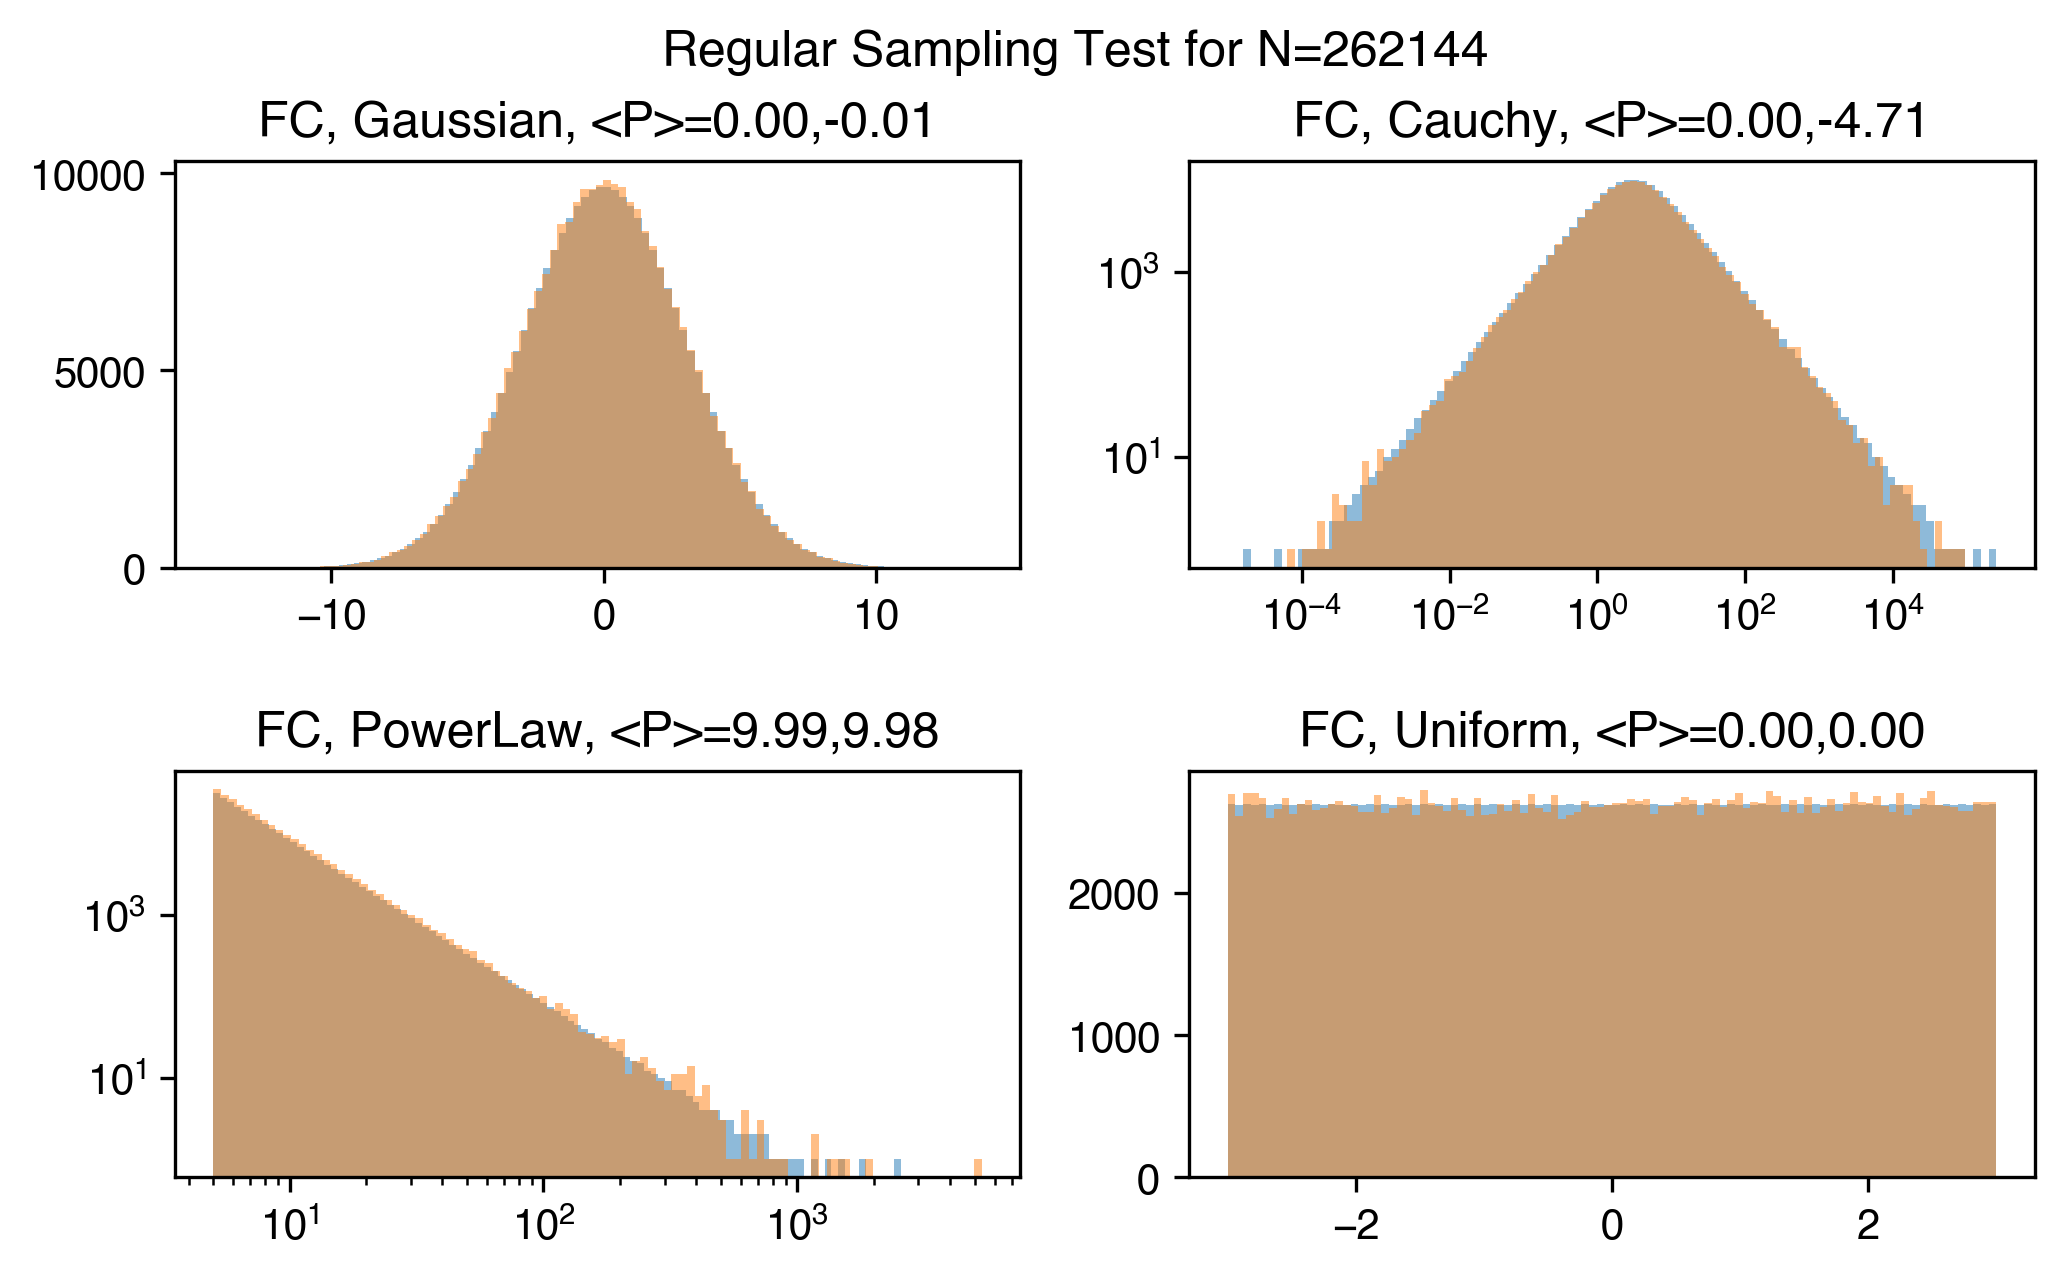

In [3]:
Initialize = swing.annealed_multilayer.Init_Anneal
dgr_types = ["SF", "ER", "Lattice", "FC"][-1:]
power_types = ["Gaussian", "Cauchy", "PowerLaw", "Uniform"]  # [1:-1]
RegularSamplings = [True, False]

params["N"] = 2**18

N_ROW = 2
N_COL = 2
X_SIZE = 4
Y_SIZE = 2.2

plt.rcParams["font.family"] = ["Helvetica"]
fig = plt.figure(figsize=(X_SIZE * N_COL, Y_SIZE * N_ROW), dpi=300)
spec = gridspec.GridSpec(ncols=N_COL, nrows=N_ROW, figure=fig, hspace=0.5)
axes = []


axi = 0
for degree_type in dgr_types:
    for power_type in power_types:
        ax = fig.add_subplot(spec[axi // N_COL, axi % N_COL])  # row, col
        pms = []
        for RegularSampling in RegularSamplings:
            params["degree_type"] = degree_type
            params["power_type"] = power_type
            params["RegularSampling"] = RegularSampling

            inits = swing.annealed_multilayer.single_layer_initialize(
                Initialize, params
            )
            (
                m,
                gamma,
                P,
                K,
                degree,
                totalDegree,
                meanDegree,
            ) = swing.annealed_multilayer.single_layer_configuration(
                inits, params
            )
            pms.append(P.mean())

            if power_type in ["Cauchy", "PowerLaw"]:
                if P.min() < 0:
                    _min = -5
                else:
                    _min = np.log10(P.min())
                bins = np.logspace(_min, np.log10(P.max()), 100)
            else:
                bins = 100
            plt.hist(P, bins=bins, alpha=0.5)

        if power_type in ["Cauchy", "PowerLaw"]:
            plt.xscale("log")
            plt.yscale("log")
        plt.title(f"{degree_type}, {power_type}, <P>={pms[0]:.2f},{pms[1]:.2f}")
        axi += 1

plt.suptitle(f"Regular Sampling Test for N={params['N']}")

# 등간격으로 뽑혔을 때 만족해야 하는 조건들

- $$\large\int_{-\infty}^{\omega_i}g(\omega)d\omega = \frac{-0.5+i}{N}, i=1,2,...,N.$$
- $$\large g(\omega, \lambda) = \omega^{-\lambda}$$
- $$\large G(\omega, \lambda) = \omega^{-\lambda+1}$$

In [4]:
params["degree_type"] = "SF"
params["power_type"] = "PowerLaw"
params["RegularSampling"] = True
params["zero_mean_power"] = True
params["N"] = 3000
inits = swing.annealed_multilayer.single_layer_initialize(Initialize, params)
(
    m,
    gamma,
    P,
    K,
    degree,
    totalDegree,
    meanDegree,
) = swing.annealed_multilayer.single_layer_configuration(inits, params)

In [8]:
P.mean(), degree.mean()

(-7.579122514774402e-17, 8.678)

In [9]:
N = params["N"]
gamma = params["degree_exp"]
int(np.power(N, 1 / (gamma - 1))), degree.max()

(54, 52)

In [5]:
P.mean(), degree.mean()

(7.579122514774402e-17, 9.399)

In [6]:
N = params["N"]
gamma = params["degree_exp"]
int(np.power(N, 1 / (gamma - 1))), degree.max()

(54, 273)

# Prob vs Regular
- N=3000, gamma=3.0 일 때,
    - regular sampling 하면 원리대로라면 degree.max()가 273까지 나옴
    - 하지만, cutoff를 정해버리면 52까지밖에 안나오는 현상